# SVM with kernel approximation

During this pratical session your goal is to implement two approaches to approximate a Gaussian kernel SVM problem by means of a low-rank approximation of the kernel. These approximations enable to the apply Gaussian SVM problem to large-scale problems.

The practical session is composed of the following steps : 

A) Start by defining some useful functions and load the data.

B) Observe the impact of the size of the training data set on the classification accuracy, the learning and testing times for Gaussian-kernel and linear-kernel SVMs. 

C) Implement two approaches to approximate the Gaussian kernel ("Nyström" and "Rahimi-Recht") and compare the quality of the approximations as a function of the dimension of the new low-rank representations. 

D) Observe the impact of the dimension of the new representations on the classification accuracy and the learning/testing times. 

Your work is tagged in the document by the keyword `TODO`.

## To upload
> `TODO` 
> You have to upload on Moodle an HTML export of the notebook which includes the output of cells.
> This submission is done once per group of two students working together.
> The deadline for the submission is **on Wednesday February 15th, at 8pm**.
> (The answer to questions may be written in french)

> `TODO` Write hereafter the first name and NAME of both students
>
> * A Zixuan WANG
> * B

# A. Definitions and data loading
## A.1 Module loading

In [1]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import describe
from time import time

# Import datasets, classifiers and performance metrics
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import (RBFSampler,
                     Nystroem)
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.decomposition import PCA

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

## A.2 Definition of some useful functions
To compile but not to understand at this point (You may come back on this later on when these functions are called to understand precisely what is done). 

In [2]:
def test_classifier(model, nb_train):
  t = time()
  model.fit(data_train[:nb_train], targets_train[:nb_train])
  t = time() - t
  print(f'------ nb_train : {nb_train} ------')
  print(f'learning time: {t:{4}.{2}}s')
  
  t = time()
  score = model.score(data_test, targets_test) 
  t = time() - t
  print(f'testing time: {t:{4}.{2}}s')
  print(f'accuracy: {score}\n')

In [3]:
def run_exp_nbex(nb_train_list, algs, labels):
  
  all_scores = []
  all_learn_times = []
  all_tests_times = []
  
  for alg in algs:
    scores = []
    learn_times = []
    tests_times = []    
    for nb_train in nb_train_list:
      t = time()
      alg.fit(data_train[:nb_train], targets_train[:nb_train])
      t = time() - t
      learn_times.append(t)
      
      t = time()
      scores.append(alg.score(data_test, targets_test))
      t = time() - t
      tests_times.append(t)
      
    all_scores.append(scores)
    all_learn_times.append(learn_times)
    all_tests_times.append(tests_times)    
  
  plt.figure(figsize=(16, 8))
  # --- accuracy = f(nb examples)
  plt.subplot(221)
  for i in range(len(algs)):
    plt.plot(nb_train_list, all_scores[i], label=labels[i])
  plt.legend()
  plt.grid()
  plt.xlabel('nb samples')
  plt.ylabel('classification accuracy')
  
  # --- accuracy = f(learning time)
  plt.subplot(222)
  for i in range(len(algs)):
    plt.plot(all_learn_times[i], all_scores[i], label=labels[i])
  plt.legend()
  plt.grid()
  plt.xlabel('learning time')
  plt.ylabel('classification accuracy')
  
  # --- test time = f(nb examples)
  plt.subplot(223)
  for i in range(len(algs)):
    plt.plot(nb_train_list, all_tests_times[i], label=labels[i])
  plt.legend()
  plt.grid()
  plt.xlabel('nb samples')
  plt.ylabel('test time')  
  
  # --- learning time = f(nb examples)
  plt.subplot(224)
  for i in range(len(algs)):
    plt.plot(nb_train_list, all_learn_times[i], label=labels[i])
  plt.legend()
  plt.grid()
  plt.xlabel('nb samples')
  plt.ylabel('learning time')

In [4]:
def run_exp_approx(data_train, approx_sizes, algs, labels):
  
  reference_kernel = rbf_kernel(data_train, gamma=0.001)
  all_scores = []
  
  for alg in algs:
    scores = []
    for approx_size in approx_sizes:
      if  isinstance(alg, Nystroem) and approx_size <= data_train.shape[0]:
        alg.set_params(n_components = approx_size)
        data_transformed = alg.fit_transform(data_train)
        scores.append(np.linalg.norm(reference_kernel - data_transformed @ data_transformed.transpose()))
      elif not isinstance(alg, Nystroem):
        data_transformed = alg(data_train, approx_size)
        scores.append(np.linalg.norm(reference_kernel - data_transformed @ data_transformed.transpose()))
    all_scores.append(scores)

    
  plt.figure(figsize=(16, 4))
  # --- approximation error = f(nb features)
  plt.subplot(221)
  for i in range(len(algs)):
    plt.plot(approx_sizes[:len(all_scores[i])], all_scores[i], label=labels[i])
  plt.axvline(x=data_train.shape[0], color='black', linestyle=':', label='Nyström limit')
  plt.legend()
  plt.grid()
  plt.xscale('log')
  plt.xlabel('nb components')
  plt.ylabel('$||K - \\tilde X\\tilde X^t||_2$')

  plt.subplot(222)
  for i in range(len(algs)):
    plt.plot(approx_sizes[:len(all_scores[i])], all_scores[i], label=labels[i])
  plt.axvline(x=data_train.shape[0], color='black', linestyle=':', label='Nyström limit')
  plt.legend()
  plt.grid()
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('nb components')
  plt.ylabel('$||K - \\tilde X\\tilde X^t||_2$')

In [5]:
def run_exp_svm_approx(nb_train, algs, labels, nb_feat_list):

  all_scores = []
  all_learn_times = []
  all_tests_times = []  
  
  for alg in algs:
    scores = []
    learn_times = []
    tests_times = []    

    if isinstance(alg, Pipeline):
      for nb_feat in nb_feat_list:
        if not isinstance(alg[0], Nystroem) or nb_feat <= nb_train:
          alg[0].set_params(n_components=nb_feat)

          t = time()
          alg.fit(data_train[:nb_train], targets_train[:nb_train])
          t = time() - t
          learn_times.append(t)
          
          t = time()
          scores.append(alg.score(data_test, targets_test))
          t = time() - t    
          tests_times.append(t)          

      all_scores.append(scores)
      all_learn_times.append(learn_times)
      all_tests_times.append(learn_times)      
    else:
      t = time()
      alg.fit(data_train[:nb_train], targets_train[:nb_train])
      t = time() - t
      all_learn_times.append([t])
      
      t = time()      
      all_scores.append([alg.score(data_test, targets_test)])
      t = time() - t
      all_tests_times.append([t])      

      
  plt.figure(figsize=(16, 8))
  # --- accuracy = f(nb features)
  plt.subplot(221)
  for i in range(len(algs)):
    if isinstance(algs[i], Pipeline):
      plt.plot(nb_feat_list[:len(all_scores[i])], all_scores[i], label=labels[i])
    else:
      plt.plot([nb_feat_list[0], nb_feat_list[-1]],[all_scores[i], all_scores[i]], linestyle='--', label=labels[i])
  plt.axvline(x=nb_train, color='black', linestyle=':', label='Nyström limit')
  plt.legend()
  plt.grid()
  plt.xlabel('nb components')
  plt.ylabel('classification accuracy')

  # --- accuracy = f(learning time)
  plt.subplot(222)
  for i in range(len(algs)):
    if isinstance(algs[i], Pipeline):
      plt.plot(all_learn_times[i], all_scores[i], label=labels[i])
    else:
      plt.plot(all_learn_times[i], all_scores[i], '*', label=labels[i])
  plt.legend()
  plt.grid()
  plt.xlabel('learning time')
  plt.ylabel('classification accuracy')
  
  # --- testing time = f(nb features)
  plt.subplot(223)
  for i in range(len(algs)):
    if isinstance(algs[i], Pipeline):
      plt.plot(nb_feat_list[:len(all_scores[i])], all_tests_times[i], label=labels[i])
    else:
      plt.plot([nb_feat_list[0], nb_feat_list[-1]],[all_tests_times[i], all_tests_times[i]], linestyle='--', label=labels[i])
  plt.axvline(x=nb_train, color='black', linestyle=':', label='Nyström limit')
  plt.legend()
  plt.grid()
  plt.xlabel('nb components')
  plt.ylabel('testing time')  
  
  
  # --- learning time = f(nb features)
  plt.subplot(224)
  for i in range(len(algs)):
    if isinstance(algs[i], Pipeline):
      plt.plot(nb_feat_list[:len(all_scores[i])], all_learn_times[i], label=labels[i])
    else:
      plt.plot([nb_feat_list[0], nb_feat_list[-1]],[all_learn_times[i], all_learn_times[i]], linestyle='--', label=labels[i])
  plt.axvline(x=nb_train, color='black', linestyle=':', label='Nystroem limit')
  plt.legend()
  plt.grid()
  plt.xlabel('nb components')
  plt.ylabel('learning time')

## A.3 Data loading
For those who are not familiar with it, you may have a look at the meaning of the command "fetch_openml" and the OpenML databases. 

In [6]:
# load MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(X.shape)

(70000, 784)


In [7]:
max_train_samples = 50000

data_train, data_test, targets_train, targets_test = train_test_split(
  X, y, train_size=max_train_samples, test_size=10000)

scaler = StandardScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

# B. Impact of the size of the training set

## B.1 Definition of the target problem

In this practical session, we consider an SVM classification problem with Gaussian and linear kernels. 

`TODO` Write the optimization problem targeted by (binary classification) SVM for a feature map $\phi:\mathbb{R}^p \rightarrow \mathbb{H}$ where $\mathbb{H}$ is a Hilbert space with inner product $\langle \cdot, \cdot \rangle_{\mathbb{H}}$ and induced norm $\|\cdot\|_{\mathbb{H}}$: 

$$
\mbox{Write your answer here}
$$

**Answers:** Soft-SVM regression in feature space

$$
\hat{h}(x)=sign(\langle\phi(x),\mathbf{\hat{w}}\rangle_\mathbb{H})
$$

where

$$
\mathbf{\hat{w}}\in \mathop{\arg\min_{\mathbf{w}\in\mathbb{H}}}\displaystyle\sum\limits_{i=1}^n [1-y_i\langle\phi(x_i),w\rangle_\mathbb{H}]_+ + \lambda\lVert \mathbf{w}\lVert_\mathbb{H}^2
$$

--------------------
How and why can you reduce this problem to a finite dimensional problem? Write the form of the corresponding problem:  

$$
\mbox{Write your answer here}
$$

**Answers:** The problem of finding the optimal hyperplane in an infinite-dimensional space can be computationally infeasible and intractable. To overcome this issue, the SVM problem can be reduced to a finite-dimensional problem by using a kernel function.

Let $\mathbf{K}\in \mathbb{R}^{n\times n}$ be such that $K_{ij}=\langle\phi(x_i),\phi(x_j)\rangle_\mathbb{H} $, then we could get

$$
\hat{h}(x)=sign(\displaystyle\sum\limits_{i=1}^n\langle\phi(x),\phi(x_i)\rangle_\mathbb{H}\hat{\alpha_i})
$$

where

$$
\hat{\alpha} \in \mathop{\arg\min_{\alpha\in\mathbb{R}^n}}1^T[\mathbf{1}-\mathbf{y}\odot\mathbf{K}\alpha]_+ + \lambda\alpha^T\mathbf{K}\alpha
$$

---------------------
Since the problem you are targetting is not a binary classification problem (but 10-ary), how does Scikit-learn proceed? 

**Answers**: Scikit-learn provides an implementation of SVM that can handle multi-class classification problems, incluing 10-ary classification problems. The strategy involves training multiple binary classifiers, where each classifier is trained to distinguish between a pair of target classes.

## B.2 Definition of the classifiers in Scikit-learn
In the practical session, we leverage the Scikit-learn Python toolbox. If you are not familiar with it, check out the toolbox document to understand the definitions below. 

In [8]:
# SVM with linear "kernel"
linear_svm = SGDClassifier(early_stopping=True)

# Accuracy and computation time while learning with nb_train=500 examples and testing with 10 000 examples 
test_classifier(linear_svm, nb_train=500)

------ nb_train : 500 ------
learning time: 0.15s
testing time: 0.05s
accuracy: 0.774



In [9]:
# SVM with Gaussian kernel
kernel_svm = svm.SVC(gamma=0.001) # TODO: set gamma to 0.001

# Accuracy and computation time while learning with nb_train=500 examples and testing with 10 000 examples 
# TODO:
test_classifier(kernel_svm, nb_train=500)

------ nb_train : 500 ------
learning time: 0.11s
testing time:  3.8s
accuracy: 0.8441



`TODO` Do you observe any difference in the learning and testing times of the two approaches? If yes, why is it so? 

**Answers**: Yes, there is a different learning and testing time between these two methods. The learning time of SVM Gaussian kernel is a bit less comapared with the SVM linear kernel **(0.11 vs. 0.15)**, while the testing time is much longer **(3.80 vs. 0.05)**.

It makes sense that we observe this result, because generally, the SVM linear model is simpler than SVM Gaussian model. So it gets faster but with a low accuracy **(0.77 vs. 0.84)**. 


## B.3 Study of the impact of the size of the training set
At this point, you may want to have a look at the definition of the function "run_exp_nbex" above.

`TODO`

1) Run the code of the first cell and interpret the results. 

**Answers**: As we could see from the first picture below, there is a gap between the trend of Linear model and Gaussian model in different metrics.

* **Under a small sample**(under 130), SVM Linear model has better accuracy than SVM Gaussian model. While in the case of large samples, SVM Gaussian modle always perform better than SVM Linear model. When we take **learning time as x-axis**, we could found the SVM Gaussian model is always better than SVM Linear model.

* The **testing time** of SVM Gaussian model increases linearly with increasing nb samples, but is always higher than that of SVM linear model. While the the **learning time** of SVM Gaussian model also increases linearly with increasing nb samples, but is always lower than that of SVM Linear model, which confirms the result we see above.

2) Increase the size of the data set in the second cell, run the code and interpret again the results.



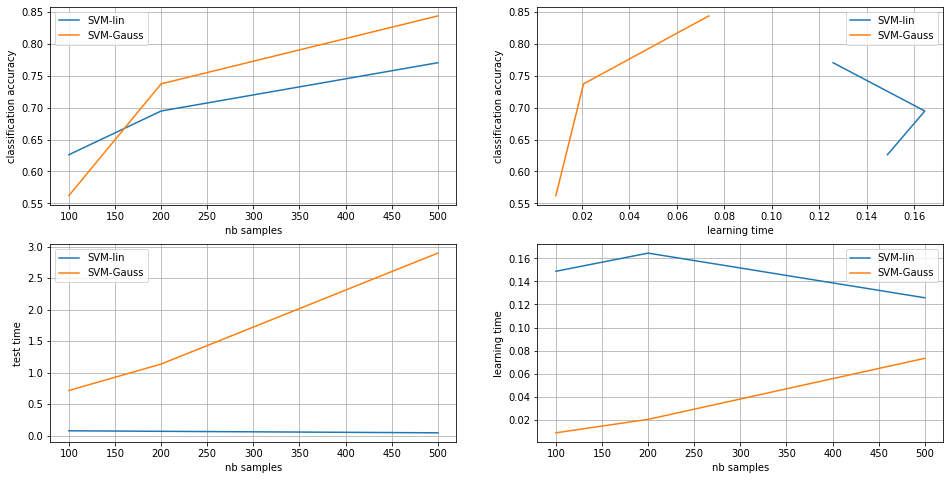

In [10]:
run_exp_nbex(nb_train_list=[100, 200, 500],  # sizes of the training set to be tested
       algs=[linear_svm, kernel_svm],        # algorithms to be tested
       labels=['SVM-lin', 'SVM-Gauss'])      # labels corresponding to tested algorithms

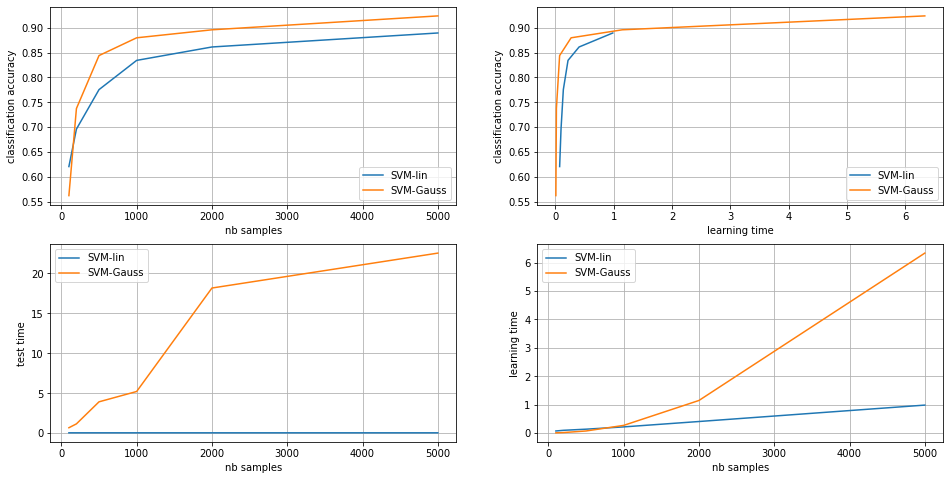

In [11]:
# TODO: What's the impact when the training dataset increases
# Generally, we could see a similar imgae with the imgae above.
# But from the picture of nb samples and leraning time(P4), we could find that with the increase of np-smaples, 
# the learning time of SVM Gaussian model is much higher than that of SVM Linear model.

# (you may go up to 50,000 examples, but it may induced HUGE computation time)
run_exp_nbex(nb_train_list=[100, 200, 500, 1000, 2000, 5000],  # sizes of the training set to be tested
       algs=[linear_svm, kernel_svm],   # algorithms to be tested
       labels=['SVM-lin', 'SVM-Gauss'])  # labels corresponding to tested algorithms

# C. Low-rank kernel approximations 

In this part, we consider two methods ("Nyström" and "Rahimi-Recht") to approximate the kernel used in the SVM classification problem. 

`TODO` Let $\mathbf{K}\in\mathbb{R}^{n \times n}$ be the kernel Gram matrix appearing in the original SVM problem. If we approximate $\mathbf{K}$ by $\hat{\mathbf{K}}=\mathbf{Z}\mathbf{Z}^T$ for some full-rank matrix $\mathbf{Z}\in\mathbb{R}^{n \times r}$, write the $r$-dimensional optimization problem one can obtain in this case: 

$$
\mbox{write your answer here}
$$

**Answer**: Assume $\mathbf{K}=\mathbf{Z}\mathbf{Z}^T$ for some full-matrix $\mathbf{Z}\in \mathbb{R}^{n\times r}$ with $r\leqslant n$.

Let $\gamma=\mathbf{Z}^T\mathbf{\alpha}$.Then we have

$$
\hat{\gamma} \in \mathop{\arg\min_{\gamma\in\mathbb{R}^r}}1^T[\mathbf{1}-y\odot\mathbf{Z}\gamma]_+ + \lambda\lVert\gamma\lVert_2^2
$$

$$
\hat{\mathbf{\alpha}} = \mathbf{Z}(\mathbf{Z}\mathbf{Z}^T)^{-1}\gamma^*
$$





## C.1 "Nyström" approximation

The Nyström approximation is already implemented in Scikit-learn and you are not asked to re-implement it. Nevertheless, your are required to answer the following questions:

`TODO`

1) What is the expression of matrix $\mathbf{Z}$ in the Nyström approximation? 

**Answers**: The Nyström approximation of $\mathbf{K}$ reads as $\mathbf{Z}\mathbf{Z}^T$ where 

$$
\mathbf{Z} = (\mathbf{K}_S)^T\mathbf{V}Σ^{-1}
$$

and 

$$
\mathbf{V} = \mbox{the matrix of eigen vectors of } \mathbf{K}_{S,S}
$$
$$
Σ = \mbox{the diagonal matrix of eigen values of } \mathbf{K}_{S,S}
$$

2) What are the operations performed by the methods "fit" and "transform" of the class "Nystroem"? (see code below and Scikit-learn documentation)

**Answers**: 
* **fit**: compute the parameters required to generate the new feature space by fitting the Nyström method to the dataset.
* **transform**: transform the dataset into reduced-dimensional space.

3) Run the code below and discuss the results.

**Answers**: As we could see from the picture below, the x-axis represents the difference between the original kernel matrix **K** and the approximated kernel **K_tilde**. The y-axis represents the frequency of occurence. Because this histogram is **centered around zero**, we could see there is **no huge difference** bewteen the origanal kernel and approximated kernel. 


200 examples of dimension 100
DescribeResult(nobs=40000, minmax=(-0.038705057643194984, 0.9999945664676726), mean=0.0018909270953876309, variance=0.0006261994407383226, skewness=22.81999920678007, kurtosis=658.6458881423656)


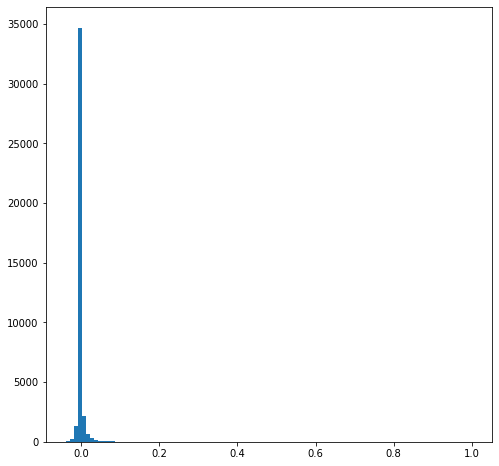

In [12]:
nystroem = Nystroem(gamma=0.001)
nystroem.set_params(n_components=100)

sub_data = data_train[:200]

# compute the parameters required to generate the new feature space
nystroem.fit(sub_data)

# generation of new features
sub_data_tilde = nystroem.transform(sub_data)
print(f'{sub_data_tilde.shape[0]} examples of dimension {sub_data_tilde.shape[1]}')

# approximation quality
K = rbf_kernel(sub_data, gamma=0.001)
K_tilde = sub_data_tilde @ sub_data_tilde.transpose()
print(describe((K-K_tilde).flatten()))
plt.figure(figsize=(8, 8))
plt.hist((K-K_tilde).flatten(), bins=100)
plt.show()

## C.2 "Rahimi-Recht" approximation

In this part, we consider the "Rahimi-Recht" approximation, also often referred to as "Random Fourier features". You are asked to implement this method. Please asnwer the following questions: 

`TODO`

1) To what kind of kernel does the Rahimi-Recht approximation apply?

**Answers**: The kernel is shown as below

$$
k(x,x^{'}) =  \int_{\mathbb{R}^p}\cos(\omega^T(x-x^{'}))d\mu(\omega)
$$

2) What is the expression of matrix $\mathbf{Z}$ in the Rahimi-Recht approximation? 

**Answers**: $\mathbf{Z}\in\mathbb{R}^{n\times 2r}$ is defined as  

$$
\mathbf{Z}=\frac{1}{\sqrt{r}}
\begin{pmatrix}
\cos(\omega_1^Tx_1) & \sin(\omega_1^Tx_1) & \dots & \cos(\omega_r^Tx_1)& \sin(\omega_r^Tx_1)\\
\vdots  & \vdots & &\vdots&\vdots\\
\cos(\omega_1^Tx_n) & \sin(\omega_1^Tx_n) & \dots & \cos(\omega_r^Tx_n)& \sin(\omega_r^Tx_n)
\end{pmatrix}
$$

3) If the considered kernel is $\kappa(\mathbf{x}_i, \mathbf{x}_j) = \exp(-\gamma\| \mathbf{x}_i-\mathbf{x}_j\|^2_2)$, what is the distribution of the "pulsations" appearing in the Rahimi-Recht approximation? 

**Answers**: With this considered kernel, the pulsations are from a **Gaussain distribution** with mean zero and covariance matrix equal to the identity metrix. It ensures that each random frequency has an **equal contribution** to the approximation.

4) Implement and test the functions `draw_direction()` and `transform_data()` below.

5) Run the code in the third cell and discuss the quality of the obtained approximation. 

**Answers**: As we could see from the histogram picture below, it's a distribution in **(-0.4, 0.4)** and peaks around zero. This indicates the true kernel matrix and its approximation obtained thorugh the **Rahimi-Recht method** is very similar.

In [13]:
def draw_directions(n_features, n_components=100, gamma=1.):
  """ Draw the random directions used to transform the data.
  
  Parameters
  ----------
  n_features : int
    Number features in the original space.
  n_components : int, default=100
    Number of Monte Carlo samples per original feature.
    Equals the dimensionality of the computed feature space.
    Has to be even.
  gamma : float, default=1.0
    Parameter of RBF kernel: exp(-gamma * x^2)
  Returns
  -------
  W : array-like, shape (n_components/2, n_features)
    D directions, où D = n_features/2.
  """
  # TODO: to implement
  W = np.zeros((int(np.floor(n_components/2)), n_features))

  for i in range(int(np.floor(n_components/2))):
    W[i] = np.sqrt(2*gamma)*np.random.normal(0, 1, n_features)

  # TODO: be careful with the number of drawn directions
  return(W) 

In [14]:
def transform_data(X, W):
  """Transform the dataset.
  
  Parameters
  ----------
  X : {array-like, sparse matrix}, shape (n_samples, n_features)
    Data, where n_samples in the number of samples
    and n_features is the number of features.
  W : array-like, shape (n_components/2, n_features)
    Directions to build the new features.
  Returns
  -------
  Z : array-like, shape (n_samples, n_components)
  """
  # TODO: to implement
  Z_cos = np.cos(np.dot(X, np.transpose(W)))
  Z_sin = np.sin(np.dot(X, np.transpose(W)))
  X_new = np.concatenate([Z_cos,Z_sin], 1)/np.sqrt(W.shape[0])
  return(X_new)

In [15]:
sub_data = data_train[:200]
n_features = data_train.shape[1]

# draw directions
directions = draw_directions(n_features, n_components=100, gamma=0.001)

# generate the new features
sub_data_tilde = transform_data(sub_data, directions)
print(f'{sub_data_tilde.shape[0]} examples of dimension {sub_data_tilde.shape[1]}')

# quality of the approximation
K = rbf_kernel(sub_data, gamma=0.001)
K_tilde = sub_data_tilde @ sub_data_tilde.transpose()
print(describe((K-K_tilde).flatten()))
plt.figure(figsize=(8, 8))
plt.hist((K-K_tilde).flatten(), bins=100)
plt.show()

200 examples of dimension 100
DescribeResult(nobs=40000, minmax=(-0.32755287514953807, 0.4410307926816974), mean=-0.005205176962546555, variance=0.00694384978145812, skewness=0.11723743262916173, kurtosis=0.4428140938196816)


## C.3 Comparison of "Nyström" and "Rahimi-Recht" approximations

At this point, you may want to have a look at the definition of the function "run_exp_approx" above.

`TODO` Run the cell below and comment the results of the comparison.

**Answers**: The picture generated below compares the appproximation quality of two methods, Nystroem and RFF. It could be found that the Nystroem method is always better than RFF, which confirms that when addressing large amount of data, we perform to use the Nystroem kernel method.


In [16]:
def transform_rff_0_001(X, n_components):
  return transform_data(X, draw_directions(X.shape[1], n_components=n_components, gamma=0.001))
sub_data = data_train[:2000]
run_exp_approx(data_train=sub_data,                    # data
        approx_sizes=[10, 50, 100, 150, 500, 1000, 10**4, 10**5],  # sizes of approximation to be tested
        algs=[Nystroem(gamma=0.001), transform_rff_0_001],     # methods to be tested (Nystroem object or function to transform the data)
        labels=['Nystroem', 'RFF'])                 # label to attach to each method

# D. SVM classification with approximate kernels

In this part of the practical session, we study how the "Nyström" and "Rahimi-Recht" low-rank approximations impact the accuracy and the learning/testing times of the classification procedures. 

To start, write down how the classification decision is made when considering:

A) Nyström approximation: $\mbox{write your answer here}$ 

**Answer**: As the process we have seen in C1, the Nyström approxiamtion use the **'fit'** method to compute the parameters and **'transform'** method to generate the transform data and train a classifier.  

B) Rahimi-Recht approximation: $\mbox{write your answer here}$ 

**Answer**: As the process we have seen in C2, the Rahimi-Recht approximation generated **RFF** by using a function that takes the original data and the number of desired components. 

## D.1 Embedding the approximations into Scikit-learn functions

Before proceedings to any comparison, we first need to embed our kernel low-rank approximation in the standard tools for linear SVM classification implemented by Scikit-learn. From your answer to the previous questions, you should have come up to the following conclusions: SVM with kernel approximation is equivalent to

* First, transform the original feature $\mathbf{x}\in\mathbb{R}^p$ into another "feature" $\mathbf{z}\in\mathbb{R}^r$ (e.g., matrix $\mathbf{X}\in \mathbb{R}^{n \times p}$ becomes $\mathbf{Z}\in \mathbb{R}^{n \times r}$)
* Second, apply standard linear regression on the transformed features. 

These two operations can be embedded into a single function thanks the Scikit-learn class "Pipeline". 
An example of use of "Pipeline" to implement SVM classification with Nyström approximation of the Gaussian kernel is provided in the next cell.

`TODO` Consult the documention of Scikit-learn to understand how the class Pipeline proceeds. 

**Answers**: The Pipeline proceeds in scikit-learn is used to **streamline** a ML workflow by assembling a sequence of transform and models into a single entity. As the process we have seen below, the **nystroem_approx_svm** pipeline object was created which makes it easier to build, test and refine complex ML workflows. 


In [17]:
nystroem_approx_svm = Pipeline([("feature_map", Nystroem(gamma=0.001)),
                ("svm", svm.LinearSVC())])


nystroem_approx_svm[0].set_params(n_components=100)
test_classifier(nystroem_approx_svm, 500)

nystroem_approx_svm[0].set_params(n_components=400)
test_classifier(nystroem_approx_svm, 500)

nystroem_approx_svm[0].set_params(n_components=1000)
test_classifier(nystroem_approx_svm, 500)    # !!! warning: nb_feat has to be smaller than nb_ex

------ nb_train : 500 ------
learning time: 0.066s
testing time: 0.16s
accuracy: 0.8162

------ nb_train : 500 ------
learning time: 0.32s
testing time: 0.48s
accuracy: 0.8484



/usr/local/lib/python3.8/dist-packages/sklearn/kernel_approximation.py:885: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(


------ nb_train : 500 ------
learning time: 0.45s
testing time: 0.66s
accuracy: 0.85



To apply the same approach for the Rahimi-Recht approximation, we must create a class (say `RFF_transform`) with methods "fit" and "transform" for this approximation. 

`TODO` Complete the definition of the class `RFF_transform` below and then (in the second cell) define a new object `rff_approx_svm` concatenating the Rahimi-Recht approximation and the linear SVM classification with a code similar to

```python
mod = Pipeline([("feature_map", RFF_transform(gamma=0.001, n_components=10**3)),
            ("svm", svm.LinearSVC())])
```


In [18]:
class RFF_transform(TransformerMixin, BaseEstimator):
  """Approximates feature map of an RBF kernel by Monte Carlo approximation
  of its Fourier transform.
  It implements Random Fourrier Features.
  
  Parameters
  ----------
  gamma : float, default=1.0
    Parameter of RBF kernel: exp(-gamma * x^2)
  n_components : int, default=100
    Number of Monte Carlo samples per original feature.
    Equals the dimensionality of the computed feature space.
  Attributes
  ----------
  random_offset_ : ndarray of shape (n_components,), dtype=float64
    Random offset used to compute the projection in the `n_components`
    dimensions of the feature space.
  random_weights_ : ndarray of shape (n_features, n_components),\
    dtype=float64
    Random projection directions drawn from the Fourier transform
    of the RBF kernel.
  """
  def __init__(self, *, gamma=1., n_components=100):
    self.gamma = gamma
    self.n_components = n_components

  def fit(self, X, y=None):
    """Fit the model with X.
    Samples random projection according to n_features.
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
      Training data, where n_samples in the number of samples
      and n_features is the number of features.
    Returns
    -------
    self : object
      Returns the transformer.
    """

    n_features = X.shape[1]
    self.random_directions_ = draw_directions(n_features, self.n_components, self.gamma)
    return self

  def transform(self, X):
    """Apply the approximate feature map to X.
    Parameters
    ----------
    X : {array-like, sparse matrix}, shape (n_samples, n_features)
      New data, where n_samples in the number of samples
      and n_features is the number of features.
    Returns
    -------
    X_new : array-like, shape (n_samples, n_components)
    """
    return transform_data(X, self.random_directions_)

In [19]:
# TODO: same test as for Nyström but with Rahimi-Recht approximation
rff_approx_svm = Pipeline([("feature_map", RFF_transform(gamma=0.001, n_components=10**3)),
                      ("svm", svm.LinearSVC())])
rff_approx_svm[0].set_params(n_components=100)
test_classifier(rff_approx_svm, 500)

rff_approx_svm[0].set_params(n_components=400)
test_classifier(rff_approx_svm, 500)

rff_approx_svm[0].set_params(n_components=1000)
test_classifier(rff_approx_svm, 500)

------ nb_train : 500 ------
learning time: 0.055s
testing time: 0.14s
accuracy: 0.685

------ nb_train : 500 ------
learning time: 0.18s
testing time:  0.4s
accuracy: 0.7914

------ nb_train : 500 ------
learning time: 0.44s
testing time:  1.4s
accuracy: 0.824



## D.2 Comparison of the approximations in terms of accuracy and learning/testing times

`TODO` Run the two following celles and discuss the results.

**Answers**: The picture below compares the performance of 4 different SVM method: linear, Gaussian kernel, Nystroem and Fourier. 
* **Classification accuracy**: Gaussian and Nystroem is always better than linear and Fourier. The accuracy of linear and Gaussian stays the same with the increase of nb components and learning time, while the performance of Nystroem and Fourier gets better and better.

* **Testing time**: Guassian kernel has the highest testing time (over 3.5s), while other methods stay below 0.5s within 1000 components.

* **Learning time**: Linear and Gaussian method stay the same level (less than 0.3s), while the leraning time of Nystroem and Fourier become progressively longer as the increase of nb components.

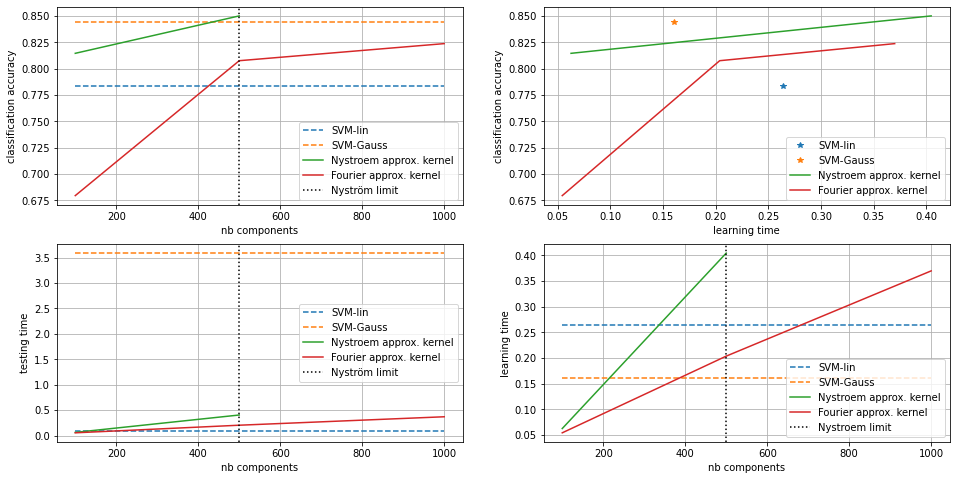

In [20]:
run_exp_svm_approx(500,               # size of the training set
          algs=[linear_svm, kernel_svm,   # algorithms to be compared
             nystroem_approx_svm,
             rff_approx_svm],
          labels=['SVM-lin', 'SVM-Gauss',  # label to attach to each algorithm
              'Nystroem approx. kernel',
              'Fourier approx. kernel'], 
          nb_feat_list=[100, 500, 1000]   # sizes of approximation to be tested (for approximation-based algorithms)
         )

**Answers**: When the nb components increase to 10000,  there is no big difference with the previous results, but we could find that the **Nystroem limit is relatively low (only 1000)**.

In [ ]:
# TODO : increase the size of the training set and of the approximation space
run_exp_svm_approx(1000,                  # size of the training set
          algs=[linear_svm, kernel_svm,      # algorithms to be compared
             nystroem_approx_svm,
             rff_approx_svm],
          labels=['SVM-lin', 'SVM-Gauss',     # label to attach to each algorithm
              'Nystroem approx. kernel',
              'Fourier approx. kernel'], 
          nb_feat_list=[100, 10**3, 10**4] # sizes of approximation to be tested (for approximation-based algorithms)
         )

## D.3 Scaling property of the approximate SVM classification procedures

In this part of the practical session, you will test different classification procedures and study how they compare in terms of accuracy, learning time and testing time.

`TODO`: Run the following cells and discuss the results. 

### SVM with Gaussian kernel

**Answers**: 
* **Learning time and testing time** : Increase dramatically with increasing components size
* **Accuracy**: Slightly increase from 0.87 to 0.96.

In [ ]:
test_classifier(kernel_svm, 1000)

------ nb_train : 1000 ------
learning time: 0.21s
testing time:   3.3s
accuracy: 0.8736



In [ ]:
test_classifier(kernel_svm, 5000)

------ nb_train : 5000 ------
learning time:  2.7s
testing time:  2e+01s
accuracy: 0.9287



In [ ]:
test_classifier(kernel_svm, 20000)

------ nb_train : 20000 ------
learning time: 6.4e+01s
testing time:  5.2e+01s
accuracy: 0.9525



In [ ]:
test_classifier(kernel_svm, 50000)

------ nb_train : 50000 ------
learning time: 2.8e+02s
testing time:  9.7e+01s
accuracy: 0.9645



### Linear SVM

**Answers**: We could see a early stopping after 1000 iteration
* **Learning time and accuracy** : Slightly increase with increasing components size
* **Testing time**: Always remains the same level

In [ ]:
mod = svm.LinearSVC()
test_classifier(mod, 5000)
print(f'early stopping after {mod.n_iter_} iteration while max_iter={mod.max_iter}')

------ nb_train : 5000 ------
learning time: 1.4e+01s
testing time:  0.07s
accuracy: 0.822

early stopping after 1000 iteration while max_iter=1000


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
mod = svm.LinearSVC()
test_classifier(mod, 20000)
print(f'early stopping after {mod.n_iter_} iteration while max_iter={mod.max_iter}')

------ nb_train : 20000 ------
learning time: 1.5e+02s
testing time:  0.064s
accuracy: 0.887

early stopping after 1000 iteration while max_iter=1000


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
mod = svm.LinearSVC()
test_classifier(mod, 50000)
print(f'early stopping after {mod.n_iter_} iteration while max_iter={mod.max_iter}')

------ nb_train : 50000 ------
learning time: 5.7e+02s
testing time:  0.037s
accuracy: 0.9055

early stopping after 1000 iteration while max_iter=1000


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### SVM with Gaussian kernel and Rahimi-Recht approximation

#### 5 000 examples 

In [ ]:
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=10**3)),
             ("svm", svm.LinearSVC())])
test_classifier(mod, 5000)

------ nb_train : 5000 ------
learning time:  4.1s
testing time:  1.1s
accuracy: 0.907



In [ ]:
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=10**4)),
             ("svm", svm.LinearSVC())])
test_classifier(mod, 5000)

------ nb_train : 5000 ------
learning time: 2.8e+01s
testing time:   6.6s
accuracy: 0.9269



In [ ]:
# What are the results if we use SGD to optimize the parameter of the linear SVM?
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=10**4)),
             ("svm", SGDClassifier(early_stopping=True))])
test_classifier(mod, 5000)

------ nb_train : 5000 ------
learning time: 1.3e+01s
testing time:   7.4s
accuracy: 0.9136



**Answers**: We could find that the accuracy drops a little when we use SGD to optimize the parameter with the learning time cutting in half.

#### 20 000 examples 

In [ ]:
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=10**3)),
             ("svm", svm.LinearSVC())])
test_classifier(mod, 20000)

------ nb_train : 20000 ------
learning time: 1.1e+01s
testing time:  0.71s
accuracy: 0.9259



In [ ]:
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=10**4)),
             ("svm", svm.LinearSVC())])
test_classifier(mod, 20000)

------ nb_train : 20000 ------
learning time: 8.4e+01s
testing time:   7.7s
accuracy: 0.9517



In [ ]:
# What are the results if we use SGD to optimize the parameter of the linear SVM?
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=10**4)),
             ("svm", SGDClassifier(early_stopping=True))])
test_classifier(mod, 20000)

------ nb_train : 20000 ------
learning time: 4.5e+01s
testing time:   6.4s
accuracy: 0.9292



**Answers**: We have a similar result with what we have seen in 5000 examples.

#### 50 000 examples 

In [ ]:
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=10**3)),
             ("svm", svm.LinearSVC())])
test_classifier(mod, 50000)

------ nb_train : 50000 ------
learning time: 2.6e+01s
testing time:   0.7s
accuracy: 0.93



**Answers**: I tried to run the second section for severals time, but the RAM always craches with 10000 components, so we **change it to 5000** to continue our comparaison. And we get a similar result as before.

In [22]:
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=5000)),  # change to 5000
             ("svm", svm.LinearSVC())])
test_classifier(mod, 50000)

------ nb_train : 50000 ------
learning time: 1.2e+02s
testing time:  4.2s
accuracy: 0.958



In [21]:
# What are the results if we use SGD to optimize the parameter of the linear SVM?
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=5000)),  # the same
             ("svm", SGDClassifier(early_stopping=True))])
test_classifier(mod, 50000)

------ nb_train : 50000 ------
learning time: 7.6e+01s
testing time:  5.3s
accuracy: 0.9301



### SVM with Gaussian kernel and Nyström approximation

#### 5 000 examples 

In [ ]:
mod = Pipeline([("feature_map", Nystroem(gamma=0.001, n_components=10**3)),
             ("svm", svm.LinearSVC())])
test_classifier(mod, 5000)

------ nb_train : 5000 ------
learning time:  5.6s
testing time:  1.4s
accuracy: 0.9211



#### 20 000 examples

In [ ]:
mod = Pipeline([("feature_map", Nystroem(gamma=0.001, n_components=10**3)),
             ("svm", svm.LinearSVC())])
test_classifier(mod, 20000)

------ nb_train : 20000 ------
learning time: 1.6e+01s
testing time:  1.4s
accuracy: 0.9374



In [ ]:
mod = Pipeline([("feature_map", Nystroem(gamma=0.001, n_components=10**4)),
             ("svm", svm.LinearSVC())])
test_classifier(mod, 20000)

------ nb_train : 20000 ------
learning time: 1.3e+03s
testing time: 6.7e+01s
accuracy: 0.9542



In [ ]:
# What are the results if we use SGD to optimize the parameter of the linear SVM?
mod = Pipeline([("feature_map", Nystroem(gamma=0.001, n_components=10**4)),
             ("svm", SGDClassifier(early_stopping=True))])
test_classifier(mod, 20000)

------ nb_train : 20000 ------
learning time: 1.1e+03s
testing time: 6.7e+01s
accuracy: 0.9303



**Answers**: The accuracy of SGD is worse than linearSVC while saves the learning time.

#### 50 000 examples

In [ ]:
mod = Pipeline([("feature_map", Nystroem(gamma=0.001, n_components=10**3)),
             ("svm", svm.LinearSVC())])
test_classifier(mod, 50000)

------ nb_train : 50000 ------
learning time: 3.7e+01s
testing time:  1.3s
accuracy: 0.9517



**Answers**: The same as before, the RAM crashes when n_components = 10000, so we **change it to 5000** in the following 2 parts. And we get a similar result, when we use SGD to optimize the parameter, the accuracy drops a little while the learning time decreses too.

In [ ]:
mod = Pipeline([("feature_map", Nystroem(gamma=0.001, n_components=5000)),
             ("svm", svm.LinearSVC())])
test_classifier(mod, 50000)

------ nb_train : 50000 ------
learning time: 3e+02s
testing time: 1.8e+01s
accuracy: 0.959



In [ ]:
# What are the results if we use SGD to optimize the parameter of the linear SVM?
mod = Pipeline([("feature_map", Nystroem(gamma=0.001, n_components=5000)),
             ("svm", SGDClassifier(early_stopping=True))])
test_classifier(mod, 50000)

------ nb_train : 50000 ------
learning time: 2.4e+02s
testing time: 1.8e+01s
accuracy: 0.9314

